In [4]:
#########################################################
################### Data input ##########################
#########################################################
# This part should be customized based on the database 

import pandas as pd
import numpy as np
from Pathway_Intepreter import Network, modified_fisher_exact, report
from Network2gpml import Network2gpml
from Gpml2df import gpml2df
from collections import defaultdict

#The process here is to handle the complexity of multi-datasourece and integrate them into one network
def read_input_data_merge(regulator_name = "regulator.xlsx", deg_tf_name = "ded_tf.xlsx", 
                          regulation_df = "Regulation.txt",
                          reaction_df = "Reaction.txt", 
                          tf_df = "tf.xlsx", 
                          regulonDB_df = "regulonDB.xlsx"):    
    """ read input data from different sources and merge them into one dataframe
        To handle different data sources, we need to process and merge them into one dataframe
        Args:
            regulator_name: the name of the regulator file
            deg_tf_name: the name of the deg_tf file
            process_name1-4: the name of the databse files
        Returns:
            moa_regulator_df: the dataframe of the moa_regulator
            deg_df: the dataframe of the deg
            process_df: the dataframe of the process"""
    
    # Read the input data from Excel files
    moa_regulator_df = pd.read_excel(regulator_name)
    deg_df = pd.read_excel(deg_tf_name)
    process_df1 = pd.read_excel(regulation_df)
    process_df2 = pd.read_excel(reaction_df)
    process_df3 = pd.read_excel(tf_df)
    process_df4 = pd.read_table(regulonDB_df, sep='\t')
    process_df = pd.concat([process_df1, process_df2], ignore_index=True)
    process_df = pd.concat([process_df, process_df3], ignore_index=True)
    process_df = pd.concat([process_df, process_df4], ignore_index=True)
    process_df = process_df.drop_duplicates()
    
    # Create a boolean mask of rows from EcoCyc with 'Object_to' and 'Object_from' columns
    ecocyc_mask = process_df[process_df['Sources'] == 'EcoCyc'].set_index(['Object_from', 'Object_to']).index
    # Filter rows from regulonDB that are also present in EcoCyc based on the above columns
    regulonDB_duplicates = process_df[(process_df['Sources'] == 'RegulonDB') & process_df.set_index(['Object_from', 'Object_to']).index.isin(ecocyc_mask)]
    # Drop these duplicates from the original dataframe
    process_df = process_df.drop(regulonDB_duplicates.index)
    # Reset the index if desired
    process_df.reset_index(drop=True, inplace=True)

    process_df.loc[process_df['IF_score'] == '0;0s', 'IF_score'] = np.nan

    process_df['Parsed_IF_score'] = process_df['IF_score'].str.split(';').str[0].astype(float)
    process_df['Cited_times'] = process_df['IF_score'].str.split(';').str[1].str[:-1].astype(float)  # Using float for NaN handling

    # Filter rows from EcoCyc and drop missing Parsed_IF_score values
    ecocyc_df = process_df[process_df['Sources'] == 'EcoCyc'].dropna(subset=['Parsed_IF_score'])

    # Calculate the statistics for EcoCyc data
    max_if_score = ecocyc_df['Parsed_IF_score'].max()
    q3_if_score = ecocyc_df['Parsed_IF_score'].quantile(0.75)
    q1_if_score = ecocyc_df['Parsed_IF_score'].quantile(0.25)
    q3_cited = ecocyc_df['Cited_times'].quantile(0.75)
    q1_cited = ecocyc_df['Cited_times'].quantile(0.25)
    print(max_if_score, q3_if_score, q1_if_score, q3_cited, q1_cited)
    #Print to check if the statistics are correct

    # Assign values to RegulonDB data based on the Reference column and EcoCyc IF
    for idx, row in process_df[process_df['Sources'] == 'RegulonDB'].iterrows():
        ref = row['Description']
        if ref == 'Confirmed':
            process_df.at[idx, 'Parsed_IF_score'] = max_if_score
            process_df.at[idx, 'Cited_times'] = q3_cited  
        elif ref == 'Strong':
            process_df.at[idx, 'Parsed_IF_score'] = q3_if_score
            process_df.at[idx, 'Cited_times'] = q1_cited
        elif ref == 'Weak':
            process_df.at[idx, 'Parsed_IF_score'] = q1_if_score
            process_df.at[idx, 'Cited_times'] = 0  

    # Assign NaN IF_score values with Q1 for both Parsed_IF_score and Cited_times
    process_df['Parsed_IF_score'].fillna(q1_if_score, inplace=True)
    process_df['Cited_times'].fillna(q1_cited, inplace=True)

    # If you wish to combine the values back into the original format
    process_df['IF_score'] = process_df['Parsed_IF_score'].astype(str) + ";" + process_df['Cited_times'].astype(str) + "s"
    
    return moa_regulator_df, deg_df, process_df

def interpret_start_end_data(moa_df, deg_df,key1, key2):
    """ Interpret the start and end data from the input data
        Args:
            moa_df: the dataframe of the moa_regulator
            deg_df: the dataframe of the deg
            key1: the start key
            key2: the end key
        Returns:
            start: the start data"""
    for key in moa_df.columns:
            if str('T'+str(key1)+'-T'+str(key2)) in key : 
                start = list(set(moa_df[key]))     

    for key in deg_df.columns:
            if str('T'+str(key1)+'-T'+str(key2)) in key and "U" in key : 
                u = list(set(deg_df[key]))
            elif str('T'+str(key1)+'-T'+str(key2)) in key and "D" in key :
                d = list(set(deg_df[key]))
            elif str('T'+str(key2)+'-T'+str(key1)) in key and "U" in key : 
                u = list(set(deg_df[key]))
            elif str('T'+str(key2)+'-T'+str(key1)) in key and "D" in key :
                d = list(set(deg_df[key]))
                
    return start, u, d

def generate_network(process_df):
    """ Generate the network from the input data
        Args:
            process_df: the dataframe of the process
        Returns:
            network: the network of the process"""

    network = Network()
    rscore_list = list(process_df['Parsed_IF_score'])
    attribute_list = list(process_df['Mechanism'])
    effect_list = list(process_df['Effect'])
    fro = list(process_df['Object_from'])
    to = list(process_df['Object_to'])

    #tcount, acount, pcount = 0, 0, 0
    for i in range(len(fro)):
        attrubute = attribute_list[i]
        if "transcrip" in attrubute.lower() or "sigma19 factor" in attrubute or "Translation" in attrubute or "Attenuation" in attrubute or "Antitermination" in attrubute or "cold shock protein CspA" in attrubute or "putative ARAC-type regulatory protein" in attrubute or "Fur" == attrubute or "HU" == attrubute or "tgi" == attrubute: #Transcriptional regulation
            network.add_edge(fro[i],to[i],effect_list[i],rscore_list[i],'T')
        elif "Protein-Modification" in attrubute or "Protein-Reactions" in attrubute or "Protein-Ligand-Binding-Reactions" in attrubute or "Binding-Reactions" in attrubute or "tti" == attrubute:
            network.add_edge(fro[i],to[i],effect_list[i],rscore_list[i],'A')
        elif "Reactions" in  attrubute or "Regulation" in attrubute or "TR-" in attrubute:
            network.add_edge(fro[i],to[i],effect_list[i],rscore_list[i],'P')
        else:
            print("Error attribute: ", attrubute)
    return network

############################################################
############### The orignal id_conversion modulke ##########
############################################################


Gnet = pd.DataFrame(pd.read_table("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Convertion/genes.txt"))
Gidl = list(Gnet['UNIQUE-ID'])
Gsymboll = list(Gnet['NAME'])

Pnet =  pd.DataFrame(pd.read_table("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Convertion/pro.txt"))
Pidl = list(Pnet['UNIQUE-ID'])
Psymboll = list(Pnet['NAME'])

Ennet = pd.DataFrame(pd.read_table("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Convertion/enzymes.txt"))
Enidl = list(Ennet['UNIQUE-ID'])
Ensymboll = list(Ennet['NAME'])

Trans_net = pd.DataFrame(pd.read_table("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Convertion/transunits_reorgnized.txt"))
Transl = list(Trans_net['UNIQUE-ID'])
Transymboll = list(Trans_net['NAME'])

Extral = ["EG11283","EG10820","G8205 ","EG10821;EG11544","G0-9384","G0-9121;EG12844","EG10320","G6109;G6110","EG11304","G0-16657", "EG11249;EG10571","EG10466","G6525","G6686","G6231","G7948;EG10821","EG12834","EG10836","EG11131","EG10440","EG12766","G0-10433","G7601;G7602","EG10659","G7120","G8221","G6494;EG10164","EG10442;EG10443","G0-10445"]
ExtraSymboll = ["phnE","RcsAB","gapC",'GadE-RcsB', 'sroD', 'YefM-YoeB', 'FlhDC', 'DinJ-YafQ', 'ydfE', 'yoeG', 'MazE-MazF', 'HU', 'efeU', 'rzpR', 'ykiA', 'RcsB-BglJ', 'yhdW', 'RelB-RelE','IHF', 'agaA', 'insX', 'HigB-HigA', 'nmpC', 'yegZ', 'ilvG', 'CRP-Sxy', 'HipAB',"ymjB"]
# Due to the complexity of the data, we need to handle some edge cases (mismatched IDs)

error_count = 0
Id2symbol = dict(zip(Gidl + Enidl + Pidl + Transl + Extral, 
                      Gsymboll + Ensymboll + Psymboll + Transymboll + ExtraSymboll))

###read input databases
up_stream_df, deg_df, process_df = read_input_data_merge("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/real_up_stream_regulator.xlsx",  
                                                "/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/real_deg_ids.xlsx",
                                                "/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/EcoCyc_Regulation_Reorganized#.xlsx",
                                                "/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/EcoCyc_Reaction_Reorganized#.xlsx",
                                                "/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/EcoCyc_tf_association_converted.xlsx",
                                                "/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Regulon_DB_Reorganized_mapped.txt")

Symbol2id = {}

# Iterate over the original dictionary
for id_val, symbol in Id2symbol.items():
    # Check if the symbol is already in the new dict
    if symbol in Symbol2id:
        # Preference for IDs starting with 'EG'
        if id_val.startswith('EG'):
            Symbol2id[symbol] = id_val
        # If the current list does not contain 'EG' and the new ID starts with 'G'
        elif not any(id.startswith('EG') for id in Symbol2id[symbol]) and id_val.startswith('G'):
            Symbol2id[symbol] = id_val
        # If we have no 'EG' or 'G' IDs, append to the list
        elif not any(id.startswith('EG') for id in Symbol2id[symbol]) and not any(id.startswith('G') for id in Symbol2id[symbol]):
            Symbol2id[symbol] = id_val
        # If none of the above, we have 'EG' or 'G' already and the current ID is not preferred, do nothing
    else:
        # This is the first time we see this symbol
        Symbol2id[symbol] = id_val

687526.39 1.36 0.45 38.0 0.0


###########             ###########            ###########             ###########
key1:  1 key2:  2
original_list_length: 138 missing_node_count: 34


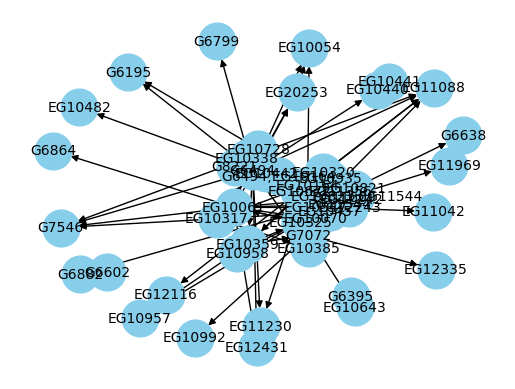

###########             ###########            ###########             ###########
key1:  2 key2:  3
original_list_length: 77 missing_node_count: 21


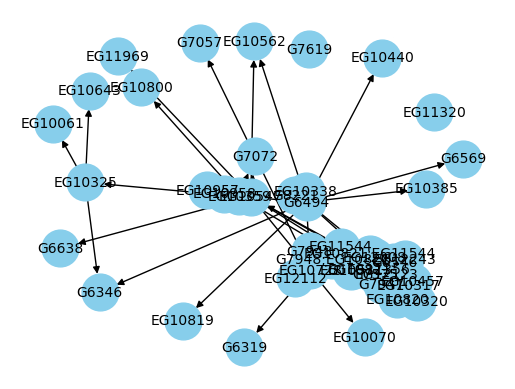

###########             ###########            ###########             ###########
key1:  3 key2:  4
original_list_length: 376 missing_node_count: 72


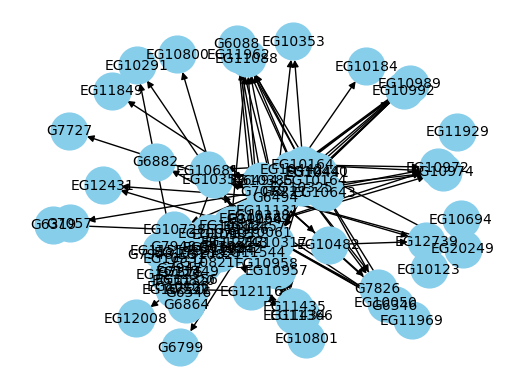

###########             ###########            ###########             ###########
key1:  4 key2:  5
original_list_length: 223 missing_node_count: 36


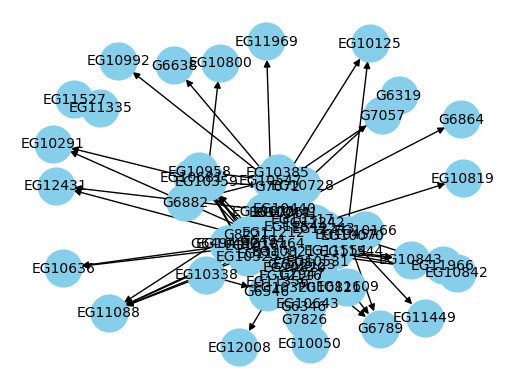

###########             ###########            ###########             ###########
key1:  5 key2:  6
original_list_length: 84 missing_node_count: 15


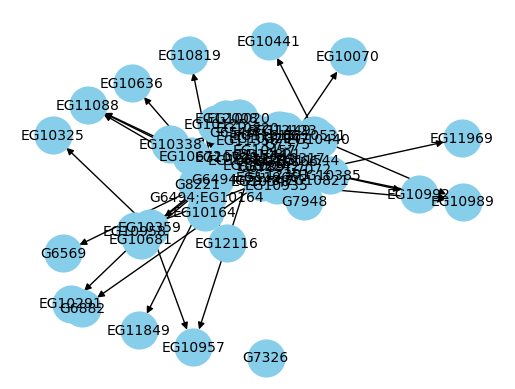

In [5]:
## Main analysis pipeline

#modify the cutoff value to get the desired results
cutoff = 5

def path_length(path_str):
    # Extracting the path from the given string
    path = path_str.split(":")[1].strip("[]").split(", ")
    # Calculating the length by identifying elements within the path (ignoring nan and tuples)
    length = sum(1 for element in path if element != 'nan' and '(' not in element)
    return length

for key1 in range(1, 6):
    key2 = key1+1
    print("###########             ###########            ###########             ###########")
    print("key1: ", key1, "key2: ", key2)
    
    #extreact start end pair
    start_node_names, up_node_names, down_node_names = interpret_start_end_data(up_stream_df, deg_df,key1,key2)
    
    network = generate_network(process_df)
    network.remove_degree_one_nodes(start_node_names,up_node_names, down_node_names) 
    
    #calculate FET statistics
    result_dictionary = network.FET_p_score_calculate_abcd(up_node_names, down_node_names)
    #delete unmathced empty value
    if '' in up_node_names:
        del up_node_names[-1]
    elif '' in down_node_names:
        del down_node_names[-1]
    names = list(result_dictionary.keys())
    abcds = list(result_dictionary.values())

    #Calculate the FET enriched TF for network construction
    FET_id = []
    for i in range(len(abcds)):
        name = names[i][0]
        abcd = abcds[i]
        p_value = modified_fisher_exact(abcd[0],abcd[1], abcd[2], abcd[3])
        # print( "P_value: ", p_value, abcd, name)
        if "Error" not in str(p_value):
            try:
                FET_id.append(name)
            except:
                continue

    start_end_pairs = []
    # Pre-filter valid nodes to reduce unnecessary iterations
    ### MUST DO HERE otherwise the remove_degree_one_nodes will cause error due to deleted nodes
    valid_start_nodes = [node for node in start_node_names if node in network.nodes]
    valid_end_nodes = [node for node in FET_id if node in network.nodes]
    # Generate start-end pairs directly without additional checks
    start_end_pairs = list(set([(start, end) for start in valid_start_nodes for end in valid_end_nodes]))
    newnetwork = Network()
    # Find the path for each valid pair
    for start_node_name, end_node_name in start_end_pairs:
        paths = network.bfs_all_paths(start_node_name, end_node_name, cutoff)
        for rpath in paths:
            if rpath:  # Simpler check for non-empty paths
                # Formatting the output once, minimizing operations within the loop
                rpath_formatted = f"{start_node_name}#{end_node_name}#:{rpath}\n"
                # Write the path to the output file
                with open("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/raw/demo_path_ouput"+str(key1)+".txt", "a") as file:
                    file.write(rpath_formatted)
                
                # Extracting the path from the given string
                path = rpath[:-3]
                if len(path) < 2: #empty path
                    newnetwork.add_node(path[0])
                else: 
                    for i in range(len(path)-1):
                        newnetwork.add_edge(path[i],path[i+1],rpath[-3],rpath[-1],'P')
    Network2gpml(newnetwork, Id2symbol, Symbol2id, process_df, savepath = str("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/raw/converted_pathway"+str(key1)+".gpml"))                        
    newnetwork.draw_network()    




In [6]:
from Pathway_Intepreter import path_length, report
from collections import defaultdict

for i in range(1,6):
    key1 = i
    # Default dictionary to hold paths by their lengths
    paths_by_length = defaultdict(list)

    # Reading the file
    with open("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/raw/demo_path_ouput"+str(key1)+".txt", "r") as file:
        for line in file:
            line = line.strip()  # Removing leading/trailing whitespace
            length = path_length(line) # Getting the path length
            paths_by_length[length].append(line) # Storing the path with its length

    # Sorting the paths by length and selecting the top 20
    top_20_lengths = sorted(paths_by_length.keys())[:20]
    top_20_lengths = sorted(top_20_lengths)

    f3 = open("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/top20/demo_path_converted_ouput"+str(key1)+".txt", "w")

    # Printing the top 20 paths with the shortest length
    for length in top_20_lengths:
        for path in paths_by_length[length]:
            f3.write(path + '\n')

report("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/top20", "/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/")

key1:  1 key2:  2
key1:  2 key2:  3
key1:  3 key2:  4
key1:  4 key2:  5
key1:  5 key2:  6
{'EG10385': 0.014654261342190696, 'EG12335': 0.0011795123424171519, 'EG10442': 0.007435645806597725, 'G6602': 5.661659243602329e-05, 'EG10061': 0.01538084094511966, 'G7072': 0.06275949271533182, 'EG10728': 0.022693817468106, 'G6195': 0.0007077074054502911, 'EG10325': 0.035545783951083286, 'G7546': 0.0009341737751943843, 'G6395': 5.661659243602329e-05, 'EG10643': 0.0013021816260285358, 'EG10359': 0.02980863591756626, 'EG10070': 0.006926096474673516, 'G6864': 0.0005378576281422213, 'EG12431': 0.0013021816260285358, 'EG10957': 0.0037461311995168746, 'G6494;EG10164': 0.01355023778968824, 'EG10164': 0.007501698497773086, 'EG10958': 0.009775798293953353, 'EG12243': 0.06989318336227075, 'EG10457': 0.06626028534762593, 'EG10338': 0.018372084245489556, 'EG11088': 0.005397448478900887, 'G6494': 0.0756114591983091, 'EG10547': 0.05090775269872427, 'EG10992': 0.00230240809239828, 'EG11544': 0.06485430663546467

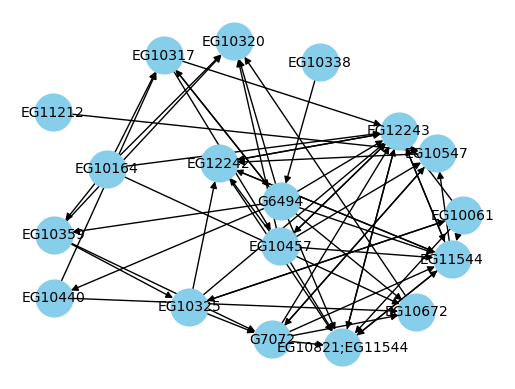

In [7]:
from collections import Counter
from scipy.stats import norm
import math
import glob
import os

def calculate_observed_frequency(front_nodes_to_keep, total_files, node_frequency_per_idx_counters):
    """This function calculates the observed frequency of each node in the front_nodes_to_keep list
    Args: 
        front_nodes_to_keep: list of tuples containing the node, repeat_count, and file_idx
        total_files: total number of files
        node_frequency_per_idx_counters: dictionary of Counter objects for each file index
    Returns:
        observed_frequency: dictionary of observed frequencies for each node
        """
    observed_frequency = {}
    for node,_,time_point in front_nodes_to_keep:
        frequency = node_frequency_per_idx_counters[time_point][node]
        if node not in observed_frequency:
            observed_frequency[node] = [0]*total_files
            observed_frequency[node][time_point] = frequency
        else:
            observed_frequency[node][time_point] = frequency
    return observed_frequency

def Z_test_for_filter(nodes_to_keep, total_files, mean_frequency_dic, observed_frquency_dic, std_dev):
    """This function calculates the p-value for each node in the nodes_to_keep list using the Z-test
    Args:
        nodes_to_keep: list of tuples containing the node, repeat_count, and file_idx
        total_files: total number of files
        mean_frequency_dic: dictionary of mean frequencies for each node
        observed_frquency_dic: dictionary of observed frequencies for each node
        std_dev: standard deviation of the observed frequencies
    Returns:
        nodes_to_keep_based_on_pvalue: list of nodes to keep based on p-value"""
    unique_nodes = set(node for node, _, _ in nodes_to_keep)
    print(mean_frequency_dic)
    nodes_to_keep_based_on_pvalue = []
    # Calculate p-values using Z-test
    for node in unique_nodes:
        mean_frequency = mean_frequency_dic.get(node, 0)
        for time_point in range(0, total_files):
            observed_frquency = observed_frquency_dic[node][time_point]
            z_score = (observed_frquency - mean_frequency) / std_dev
            p_value = 2 * (1 - norm.cdf(abs(z_score)))
            if p_value < 0.05:
                nodes_to_keep_based_on_pvalue.append(node)
    nodes_to_keep_based_on_pvalue = list(set(nodes_to_keep_based_on_pvalue))
    return nodes_to_keep_based_on_pvalue

# Initialize counters and lists
end_node_frequency_cross_file_counter = Counter()  # {Node: count in all files}
node_frequency_cross_file_counter = Counter()  # {Node: count in all files}
node_frequency_per_idx_counters = {}  # {time_point: Counter}
front_nodes_to_keep = []  # [(Node, repeat_count, file_idx)]
nodes_already_kept = set()

# Initialize your Network object and other variables here ...
network = Network()
start, end = [], []
last_nodes_dict = {}  # {Node: [file_idx, ...]}
front_nodes_to_keep = []  # [(Node, repeat_count, file_idx)]

# Reading files
directory_path = "/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/top20"
for time_point, filepath in enumerate(sorted(glob.glob(os.path.join(directory_path, "*")))):
    # Initialize Counter for this time_point
    node_frequency_per_idx_counters[time_point] = Counter()  # Initialize Counter for this time_point
    file_attribute = f"{time_point+1}-{time_point+2}" 

    key1 = time_point + 1
    key2 = time_point + 2
    print("key1: ", key1, "key2: ", key2)
    
    start_node_names, up_node_names, down_node_names = interpret_start_end_data(up_stream_df, deg_df,key1,key2)
    degs = up_node_names + down_node_names
    degs = [x for x in degs if not (isinstance(x, float) and math.isnan(x))]
    converted_deg = [Id2symbol[Id] for Id in degs if Id in Id2symbol]
    
    with open(filepath, 'r') as f:
        for line in f:
            segments = line.strip().split(":")
            path_info = eval(segments[1])
            if path_info != []:
                nodes_in_path = path_info[0:-3] 
                nodes_in_path = [node for node in nodes_in_path if node != 'nan']

                for node in nodes_in_path:
                    node_frequency_cross_file_counter[node] += 1
                    node_frequency_per_idx_counters[time_point][node] += 1

                last_node = nodes_in_path[-1]
                # Count occurrences of last node in the current time_point file
                end_node_frequency_cross_file_counter[last_node] += 1

                start_node = nodes_in_path[0]


                # Update last_nodes_dict and nodes_to_keep
                if start_node in last_nodes_dict:
                    for prev_idx in last_nodes_dict[start_node]:
                        if prev_idx >= time_point - 5 and (start_node , time_point) not in nodes_already_kept:
                            nodes_already_kept.add((start_node , time_point))  # Add to the set
                            front_nodes_to_keep.append((start_node , 1, time_point))
                            break
                        elif prev_idx >= time_point - 5 and (start_node , time_point) in nodes_already_kept:

                            for i, (node, repeat_count, file_idx) in enumerate(front_nodes_to_keep):
                                # Check if the current tuple matches the target node and file_idx
                                if node == start_node and file_idx == start_node:
                                    # Update the repeat_count by 1
                                    new_repeat_count = repeat_count + 1
                                    # Update the tuple in the list
                                    front_nodes_to_keep[i] = (node, new_repeat_count, file_idx)
                                                                        
                if last_node in last_nodes_dict:
                    last_nodes_dict[last_node].append(time_point)
                else:
                    last_nodes_dict[last_node] = [time_point]

                # Existing code for adding edges
                effect = 1
                score = 1
                start.append(nodes_in_path[0])
                end.append(last_node)
                for i in range(len(nodes_in_path) - 1):
                    from_node = nodes_in_path[i]
                    to_node = nodes_in_path[i + 1]
                    network.add_edge(from_node, to_node, effect, score, file_attribute)

# Compute top 10% nodes for each time_point
top_10_percent_nodes_per_idx = {}
top_25_percent_nodes_per_idx = {}
for time_point, counter in node_frequency_per_idx_counters.items():
    total_nodes = len(counter)
    top_10_percent_count = int(total_nodes * 0.1)
    top_10_percent_nodes = counter.most_common(top_10_percent_count)
    top_10_percent_nodes_per_idx[time_point] = set(node for node, _ in top_10_percent_nodes)

    top_25_percent_count = int(total_nodes * 0.5)
    top_25_percent_nodes = counter.most_common(top_25_percent_count)
    top_25_percent_nodes_per_idx[time_point] = set(node for node, _ in top_25_percent_nodes)

# After you've read through all files, calculate expected frequencies and standard deviation
total_files = len(glob.glob(os.path.join(directory_path, "*")))
observed_frquency = {node: count / total_files for node, count in node_frequency_cross_file_counter.items()}
std_dev = np.std(list(observed_frquency.values()))

#top 10% nodes are kept
nodes_to_keep_based_on_frequency = [(node, count, time_point) for node, count in node_frequency_cross_file_counter.items() if node in top_10_percent_nodes_per_idx[time_point]]

front_nodes_to_keep = [(node, count, time_point) for node, count, time_point in front_nodes_to_keep if node in top_25_percent_nodes_per_idx[time_point]]
# Calculate the mean frequency of each node cross all files by normalize node_frequency_cross_file_counter
mean_frequency = {node: count / total_files for node, count in node_frequency_cross_file_counter.items()}
mean_frequency = {k: v / sum(list(mean_frequency.values())) for k, v in mean_frequency.items()}

observed_frquency = calculate_observed_frequency(front_nodes_to_keep, total_files,node_frequency_per_idx_counters)
# Compute statistics
nodes_to_keep_based_on_pvalue = Z_test_for_filter(front_nodes_to_keep, total_files, mean_frequency, observed_frquency, std_dev)

print(nodes_to_keep_based_on_frequency)
print(len(nodes_to_keep_based_on_frequency))
print(nodes_to_keep_based_on_pvalue)
print(len(nodes_to_keep_based_on_pvalue))

# core_network now contains the refined, core mechanism network
# network.prune_network(threshold = 30, start_nodes = converted_start_nodes, end_nodes= converted_end_nodes, nodes_to_keep = nodes_to_keep_based_on_frequency, universal_keep = nodes_to_keep_based_on_pvalue)
network.prune_network(threshold = 44, start_nodes = [], end_nodes= [], nodes_to_keep = nodes_to_keep_based_on_frequency, universal_keep = nodes_to_keep_based_on_pvalue)
print("After pruning:")
network.draw_network(layout = 'spring', k = 2)
network.save_network_to_txt("/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/core_network.txt", combine = True)
Network2gpml(network, Id2symbol, Symbol2id, process_df, savepath = "/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/core_network.gpml")

In [9]:
xml_path = '/Users/runbomao/Documents/class/BIOINF576/Repo/Pathway_Intepreter/Demo_data/Demo_ouput/core_network.gpml'
nodes_df, edges_df = gpml2df(xml_path)
print(nodes_df)
print()
print(edges_df)


    TextLabel          GraphId     Type
0         nac            G7072  Protein
1        arcA          EG10061  Protein
2         fnr          EG10325  Protein
3         fur          EG10359  Protein
4         sxy            G6494  Protein
5         crp          EG10164  Protein
6        gadX          EG12243  Protein
7         hns          EG10457  Protein
8         cra          EG10338  Protein
9         lrp          EG10547  Protein
10       gadE          EG11544  Protein
11       gadW          EG12242  Protein
12  GadE-RcsB  EG10821_EG11544  Protein
13       agaA          EG10440  Protein
14       ompR          EG10672  Protein
15        fis          EG10317  Protein
16      FlhDC          EG10320  Protein
17       nsrR          EG11212  Protein

        From               To  InteractionEffect
0      G7072          EG10547                 -1
1      G7072          EG12243                 -1
2      G7072          EG10672                 -1
3      G7072          EG11544              